In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_mdc/mdc_cut.pkl')
# Swap latitude and longitude because they are the wrong way rounda how many 
tmp = real['latitude'].copy()
real['latitude'] = real['longitude']
real['longitude'] = tmp

fake = pd.read_pickle('../machine_learning/generated/citybased_rnn_2/GRU-32_TD-Dense-3_mdc_64_100_adam_mae_default_cut.pkl')
# Swap latitude and longitude because they are the wrong way round
tmp = fake['latitude'].copy()
fake['latitude'] = fake['longitude']
fake['longitude'] = tmp

In [3]:
# Load the OSMNX graphs
streets_lausanne = ox.load_graphml('lausanne_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

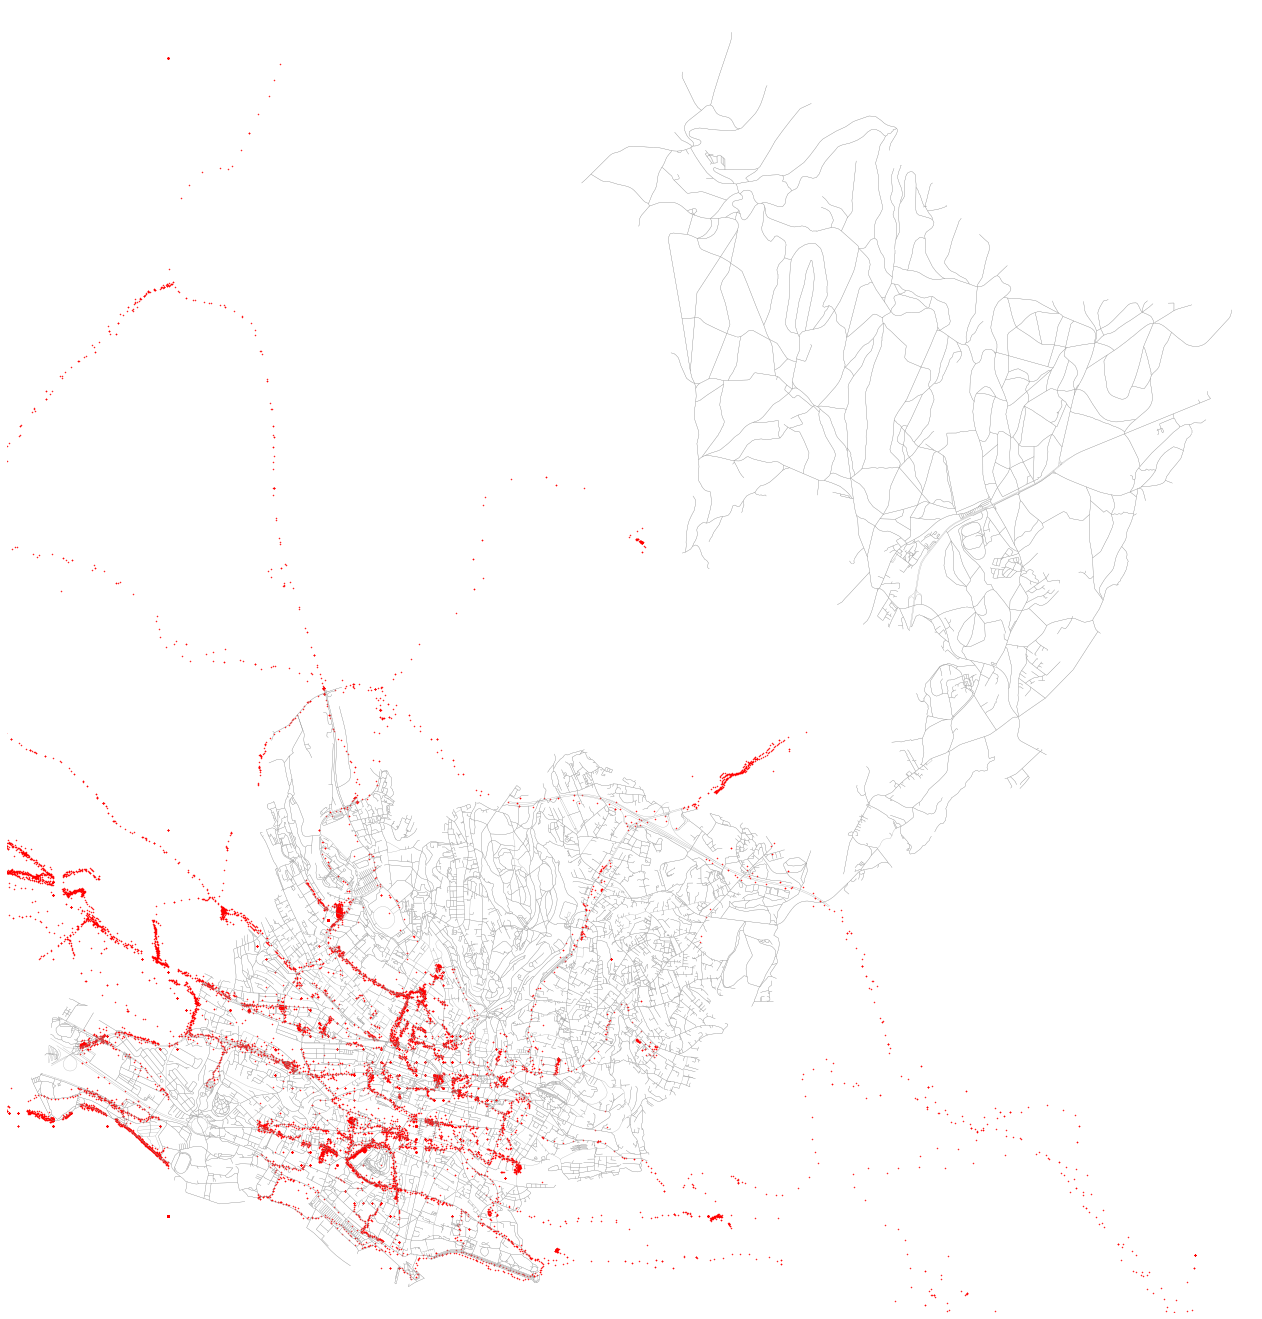

In [11]:
fig, ax = ox.plot_graph(streets_lausanne, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

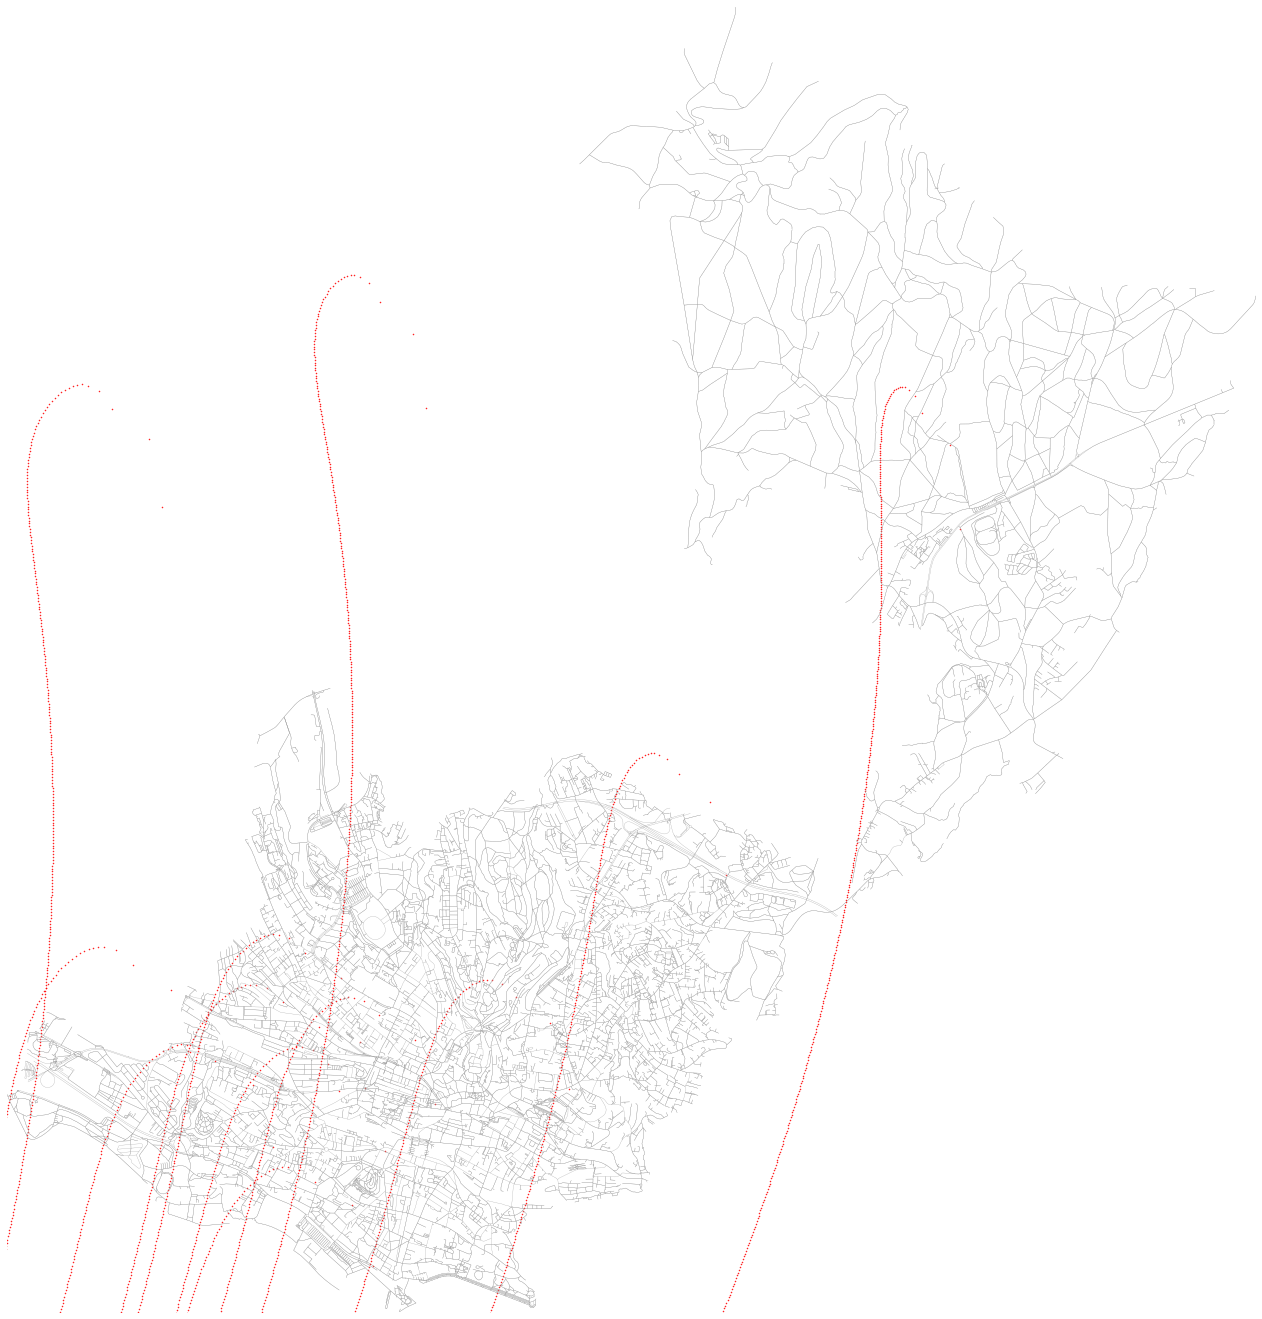

In [4]:
fig, ax = ox.plot_graph(streets_lausanne, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_mdc_rnn_2_32_3.png', dpi=200, bbox_inches='tight')

## Histogram of # records in every hour

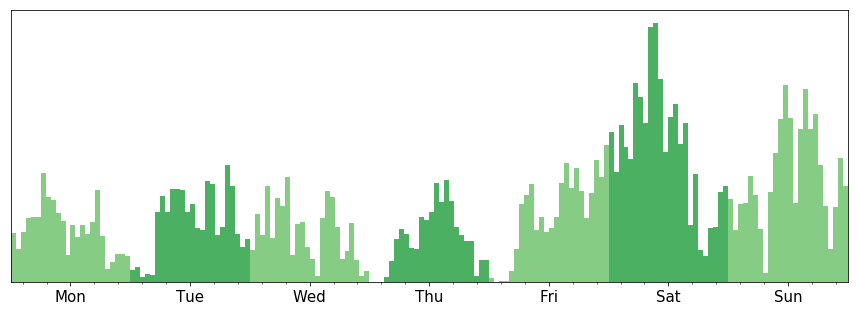

In [3]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2010-04-12 00:00:00'), pd.Timestamp('2010-04-18 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2010-04-12 00:00:00'), pd.Timestamp('2010-04-18 23:59:59'))
plt.xticks([pd.Timestamp('2010-04-12 12:00:00'), pd.Timestamp('2010-04-13 12:00:00'),
           pd.Timestamp('2010-04-14 12:00:00'), pd.Timestamp('2010-04-15 12:00:00'),
           pd.Timestamp('2010-04-16 12:00:00'), pd.Timestamp('2010-04-17 12:00:00'),
           pd.Timestamp('2010-04-18 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

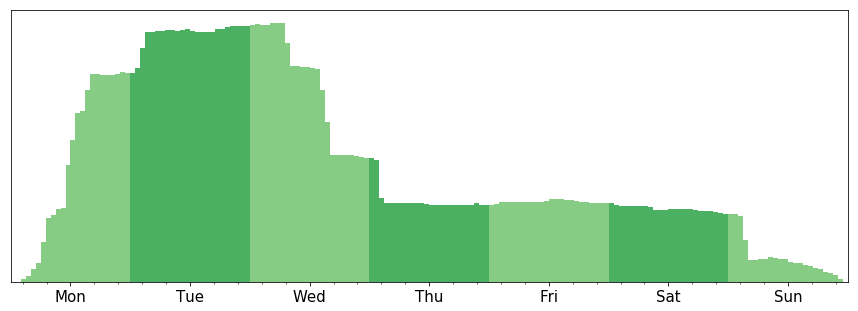

In [4]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2010-04-12 00:00:00'), pd.Timestamp('2010-04-18 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2010-04-12 00:00:00'), pd.Timestamp('2010-04-18 23:59:59'))
plt.xticks([pd.Timestamp('2010-04-12 12:00:00'), pd.Timestamp('2010-04-13 12:00:00'),
           pd.Timestamp('2010-04-14 12:00:00'), pd.Timestamp('2010-04-15 12:00:00'),
           pd.Timestamp('2010-04-16 12:00:00'), pd.Timestamp('2010-04-17 12:00:00'),
           pd.Timestamp('2010-04-18 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_mdc_rnn_2_32_3.pdf', dpi=20, bbox_inches='tight')

## Distribution of speeds

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    74058.000000
mean        13.942828
std         48.252004
min          0.000000
25%          0.000000
50%          1.692070
75%          7.008017
max       4306.586644
dtype: float64


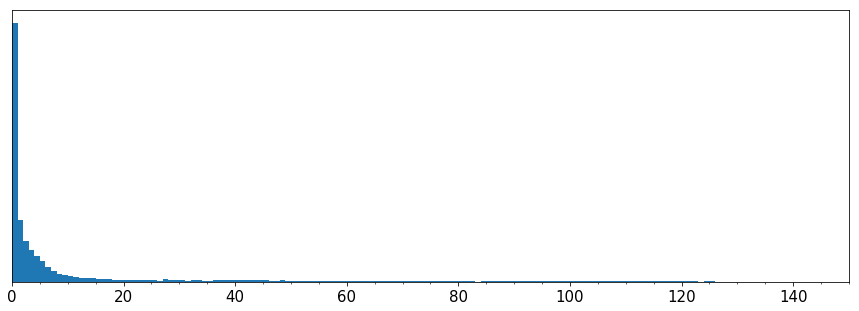

In [4]:
speed_distribution(real)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    1.647699e+06
mean     1.867996e+00
std      4.677732e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.703483e+03
dtype: float64


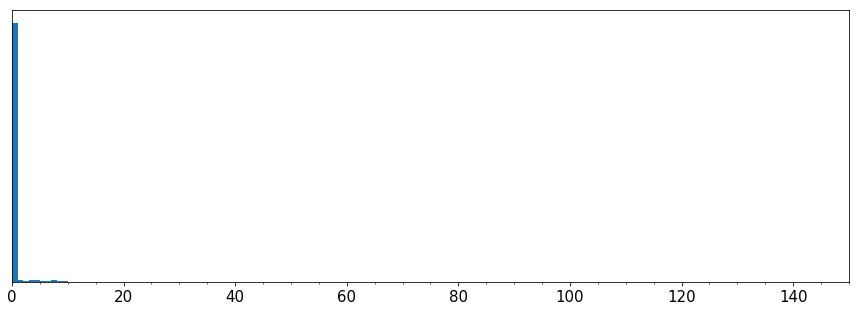

In [7]:
speed_distribution(fake)
plt.savefig('../../Images/question_speeds_mdc_rnn_2_32_3.pdf', dpi=20, bbox_inches='tight')

## One user's data

In [24]:
real.index.levels[0]

Int64Index([5477, 5479, 5925, 5928, 5944, 5945, 5950, 5953, 5957, 5958, 5964,
            5969, 5977, 5979, 5980, 5989, 5990, 5995, 6001, 6004, 6007, 6015,
            6023, 6033, 6035, 6039, 6040, 6045, 6058, 6063, 6075, 6078, 6082,
            6086, 6087, 6175, 6182, 6192, 6199],
           dtype='int64', name='user')

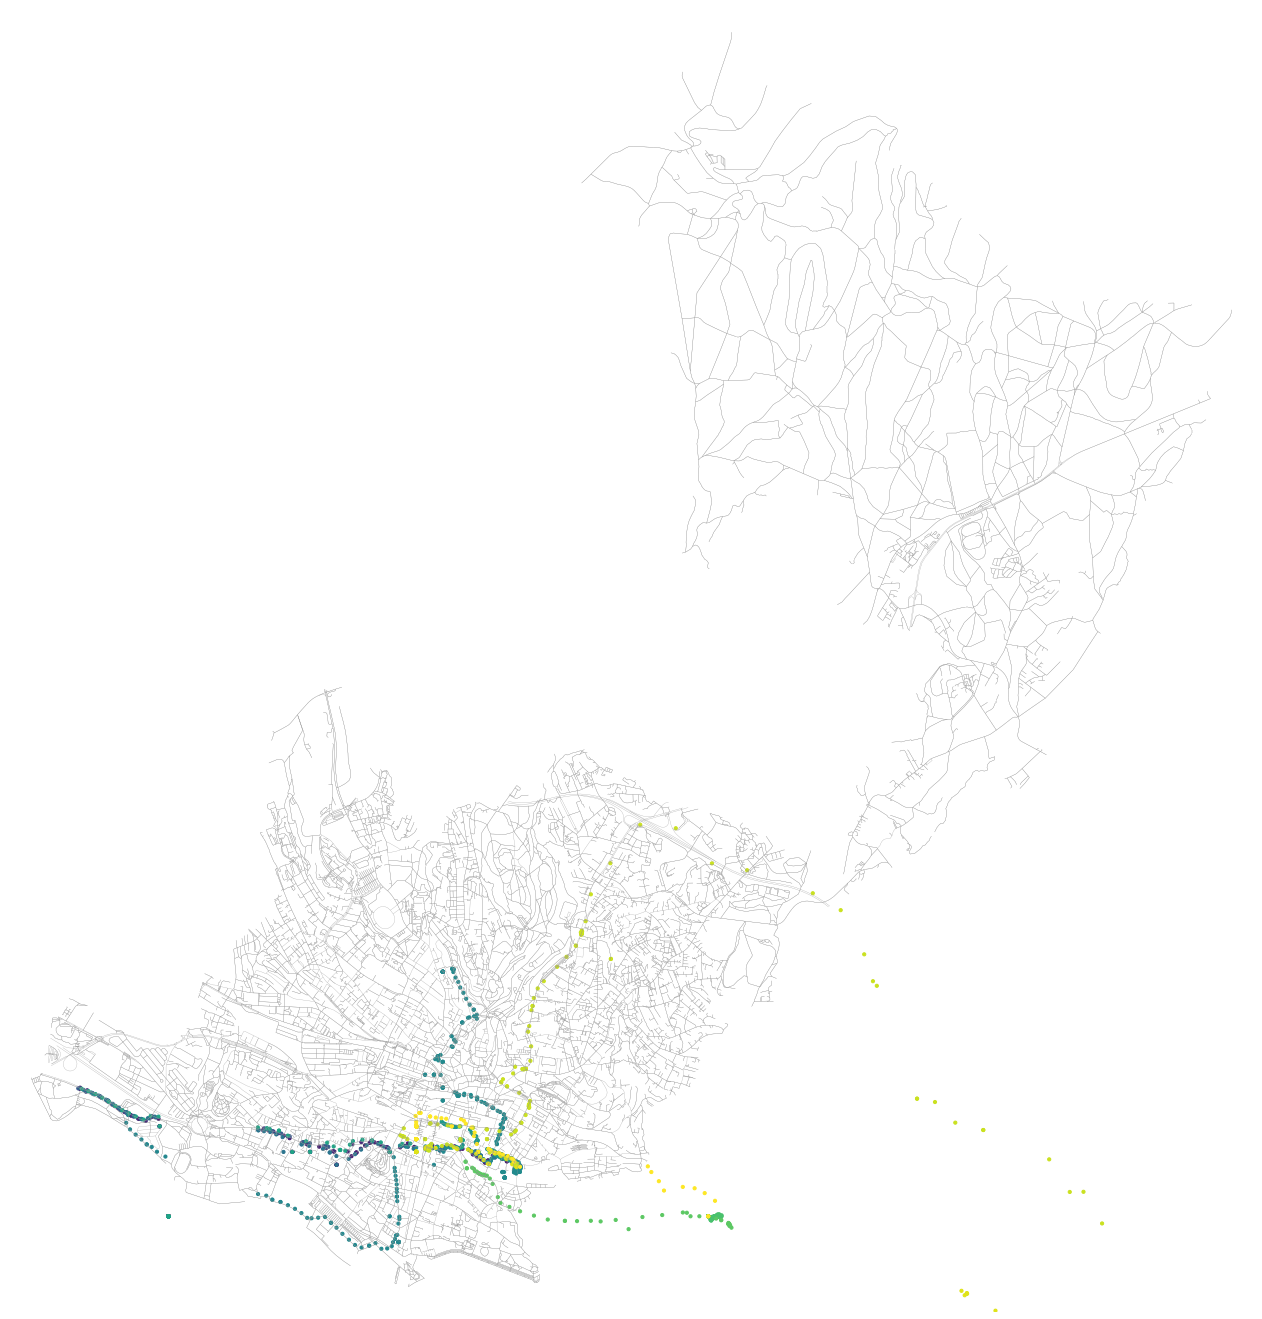

In [49]:
# 5477, 5944, 5950, 5953 -> 5953 or 5477
user = 5953
fig, ax = ox.plot_graph(streets_lausanne, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

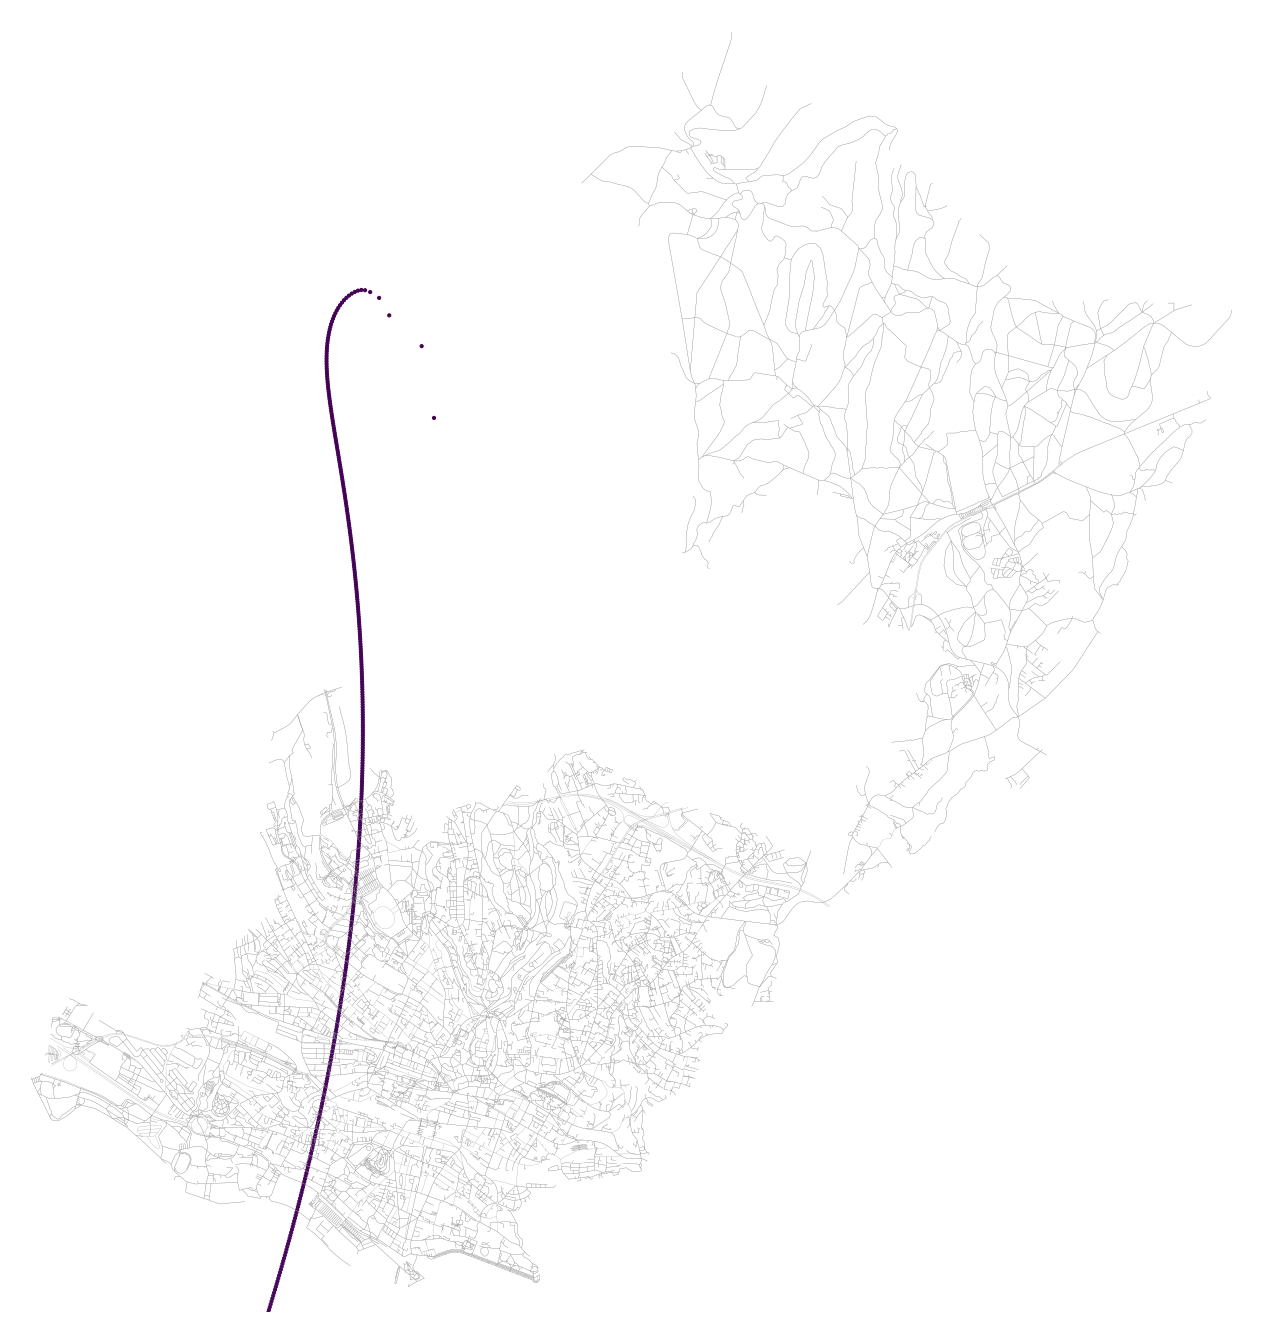

In [50]:
# 0, 3, 5, 6
user = 5
fig, ax = ox.plot_graph(streets_lausanne, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)